# STATS 250 - Student Tracker
*Find the latest version at https://github.com/lpuglisi/250GradeTracking*

After changing the file name of the Canvas grade file in section 1, you run all cells by clicking 'Cell' > 'Run All'.

## Table of Contents
* [Start Here](#first)
* [Run These](#second)
* [Explore and Customize](#third)
    * [Generally, how are my sections doing?](#thirdfirst)
    * [How did my sections do on the exams?](#thirdsecond)
    * [Who is my top 10% and bottom 10% based on the Canvas current score?](#thirdthird)
    * [How is a specific student doing?](#thirdfourth)
    * [What grade is predicted for my students?](#thirdfifth)

## 1) Start Here <a class="anchor" id="first"></a>

Start by giving a filename of the Canvas grade file you would like to anaylze.

In [1]:
#Add the filename (or file path if file is not in your current directory) of the grade file you want to import in
filename = '03_Dec_13_05_Grades-STATS_250_F17.csv'

## 2) Run These <a class="anchor" id="second"></a>

The following blocks of code do not need to be customized, they can just be run to modify the grade file from Canvas to be in a nice format. These functions will take a Canvas grade file and produce two dataframes (grades and grades2) that are easier to use for analysis. Feel free to export these files for use by running "*grades.to_csv('filename.csv')*".

In [2]:
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display, HTML

In [3]:
#This function takes a Canvas file and outputs a dataframe with a similar format to Canvas
def MrClean(file):
    "Takes a Canvas grade file location, cleans it up, outputs a dataframe"
    df = pd.read_csv(file)
    df.drop(0, inplace=True)
    df.drop(1, inplace=True)
    df.fillna(value=0,inplace=True)
    df['ind'] = range(len(df))
    #Correctly setting all the data types
    df.ix[:,1:3] = df.ix[:,1:3].astype(int)
    df.ix[:,0:6] = df.ix[:,0:6].astype(str)
    df.ix[:,6:] = df.ix[:,6:].astype(float)
    #Renaming fields to be more user friendly
    df.columns = [(x.lower()).replace(' ', '_') for x in list(df.columns.values)]
    #Pick out column names we want to keep
    prelabnm = [sub for sub in list(df.columns) if '_prelab_'in sub]
    attdnm = [sub for sub in list(df.columns) if 'attendance_l'in sub]
    tcknm = [sub for sub in list(df.columns) if 'ticket_l'in sub]
    icklnm = [sub for sub in list(df.columns) if 'iclicker'in sub]
    lecprt = [sub for sub in list(df.columns) if 'lecpart'in sub]
    hwnm = [sub for sub in list(df.columns) if 'hw_'in sub]
    exmnm = [sub for sub in list(df.columns) if 'exam_'in sub]
    wrtlnm = [sub for sub in list(df.columns) if 'write_t'in sub]
    currscrnm = [sub for sub in list(df.columns) if 'current_score'in sub]
    fnlscrnm = [sub for sub in list(df.columns) if 'final_score'in sub]
    misc = ['ind','student','id','sis_user_id','sis_login_id','section']
    keepme = misc + currscrnm + prelabnm + attdnm + tcknm + icklnm + lecprt + hwnm + exmnm + wrtlnm  + fnlscrnm
    #Get rid of test student
    df = df[df['student']!='Student, Test']
    return df[keepme]

#Pull out the mute flag and convert to 0,1 flag
activeflg = pd.read_csv(filename)
activeflg = activeflg.ix[0,:]
activeflg = activeflg.map(pd.Series([0,1],index=['Muted',np.nan]))

//anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [4]:
#These functions take the cleaned up file outputted from MrClean() and convert it to a long format
def percentscore(df):
    "This function converts the assignment points total to a percent"
    if df['assntype']=='prelab':
        scr = (df['score']/2)*100
    elif df['assntype']=='iclicker':
        scr = (df['score']/2)*100
    elif df['assntype']=='ticket':
        scr = (df['score']/2)*100
    elif df['assntype']=='homework':
        scr = (df['score']/35)*100
    elif df['assntype']=='exam':
        scr = (df['score']/75)*100
    elif df['assntype']=='lab_attendance':
        scr = (df['score']/1)*100
    elif df['assntype']=='lecture_attendance':
        scr = (df['score']/0.5)*100
    else:
        scr = df['score']
    return scr

def MrCleanAndOrganize(df):
    "This function takes the MrClean() dataframe and outputs a long format dataframe"
    dftmp = df.copy()
    dftmp.set_index(['student','id','section','ind','sis_user_id','sis_login_id'], inplace=True)
    dftmp = dftmp.stack().reset_index()
    dftmp.columns = ['student','id','section','ind','sis_user_id','sis_login_id','assignment','score']
    #Now lets create groupings for a useful assignment type flag
    cond = [(dftmp['assignment'].str.contains('_prelab_')) & (~dftmp['assignment'].str.contains('score')),
        (dftmp['assignment'].str.contains('hw_')) & (~dftmp['assignment'].str.contains('score')),
        (dftmp['assignment'].str.contains('attendance_l')) & (~dftmp['assignment'].str.contains('score')),
        (dftmp['assignment'].str.contains('ticket_l')) & (~dftmp['assignment'].str.contains('score')),
        (dftmp['assignment'].str.contains('iclicker')) & (~dftmp['assignment'].str.contains('score')),
        (dftmp['assignment'].str.contains('exam_')) & (~dftmp['assignment'].str.contains('score')),
        (dftmp['assignment'].str.contains('write_t')) & (~dftmp['assignment'].str.contains('score')),
        (dftmp['assignment'].str.contains('lecpart')) & (~dftmp['assignment'].str.contains('score')),
        (dftmp['assignment'].str.contains('current_score')),
        (dftmp['assignment'].str.contains('final_score'))]
    cats = ['prelab','homework','lab_attendance','ticket','iclicker','exam','write','lecture_attendance','current','final']
    dftmp['assntype'] = np.select(cond, cats, default='zzzz')
    dftmp['score_percent'] = dftmp.apply(percentscore,axis=1)
    #Add an mute flag for each assignment to tell if assignment is muted on Canvas
    newlab = [(x.lower()).replace(' ', '_') for x in list(activeflg.index.values)]
    act = activeflg.reset_index()
    act['index'] = newlab
    act = act.set_index(keys='index')
    act = pd.Series(act[0])
    dftmp['muteflag'] = dftmp.assignment.map(act)
    return dftmp

In [5]:
#Load in and clean up the grades
grades = MrClean(filename)
#Create a new version of grades that is in long format
grades2 = MrCleanAndOrganize(grades)

//anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


In [6]:
#Adding a quantile value for each student by each assignment's current score
currscrnm = [sub for sub in list(grades.columns) if 'current_score'in sub]
for i in currscrnm:
    lst = list(grades[i].values)
    grades['qnt_'+i] = [round(scp.stats.percentileofscore(lst,grd,'weak')) for grd in lst]

## 3) Explore and Customize <a class="anchor" id="third"></a>

The following sections try to answer specific questions about your labs. There are sections that explore the overall lab and sections that explore specific students. Subtitles indicate if you need to customize certain sections for students or exams you are interested in.

### 3.1) Generally, how are my sections doing? <a class="anchor" id="thirdfirst"></a>

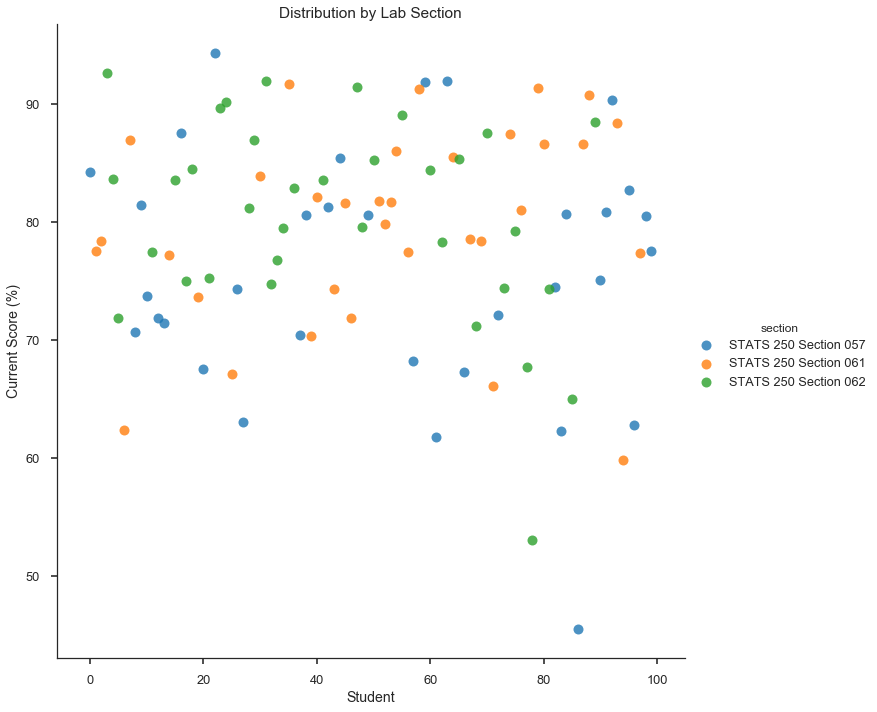

In [7]:
#Scatter plot of the all sections to see generally how students are doing (based on current score)
#Setting style of scatter
sns.set_context("poster", font_scale=0.8)
sns.set_style("ticks")

# Create scatterplot of dataframe
sns.lmplot(x='ind',y='current_score',data=grades, fit_reg=False, hue="section", size=10,scatter_kws={"marker": "D","s": 100})

# Define the labels
plt.title('Distribution by Lab Section')
plt.xlabel('Student')
plt.ylabel('Current Score (%)')

In [8]:
#Generally how is each section doing
grades.pivot_table(index='section', values=currscrnm,aggfunc=np.mean)

,current_score,exams_current_score,homework_current_score,lab_attendance_current_score,lab_iclicker_current_score,lab_iclicker_current_score,lab_iclicker_current_score,lab_iclicker_current_score,lab_resources_current_score,lab_tickets_current_score,lecture_participation_current_score,m-write_wtl_assignments_current_score,other_current_score,prelab_assignments_current_score
section,,,,,,,,,,,,,,
STATS 250 Section 057,75.910606,73.565758,83.244545,95.482121,93.389091,93.389091,93.389091,93.389091,0.0,95.482121,73.106061,82.052424,80.335152,83.700000
STATS 250 Section 061,79.864545,76.747273,89.489091,99.393939,97.520909,97.520909,97.520909,97.520909,0.0,99.393939,75.000000,95.105758,85.028182,88.763636
STATS 250 Section 062,80.475000,78.391471,88.224118,97.647059,94.652941,94.652941,94.652941,94.652941,0.0,97.647059,62.867647,82.987353,83.564706,88.680882


### 3.2) How did my sections do on the exam? <a class="anchor" id="thirdsecond"></a>

#### Enter Exam

In [9]:
#Enter 'exam_1', 'exam_2', or 'final_exam'
exam = 'exam_2'

#### Run these

In [10]:
exmflt = grades2['assignment'].str.contains(exam)
exmsum = pd.DataFrame(grades2[exmflt].groupby('section').score_percent.describe()).round(2)
exmsum

,count,mean,std,min,25%,50%,75%,max
section,,,,,,,,
STATS 250 Section 057,33.0,73.19,18.08,0.00,64.67,75.33,84.00,97.33
STATS 250 Section 061,33.0,77.60,10.64,54.00,72.00,79.33,84.67,96.00
STATS 250 Section 062,34.0,78.78,11.37,36.67,72.17,77.67,87.17,94.67


In [11]:
exmsum_plt = (exmsum.reset_index()).rename(columns={'level_1':'Stats'})
fiveplt = sns.factorplot(x='score_percent', y='Stats', col='section',kind='bar',  data=exmsum_plt)

ValueError: Could not interpret input 'score_percent'

#### Enter a Section Number

In [12]:
sct = 'Section 057'

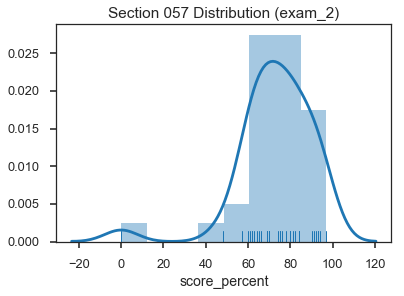

In [13]:
sns.distplot(grades2[(exmflt) & (grades2['section'].str.contains(sct))].score_percent.map(int), rug=True)
plt.axes().set_title(sct +  ' ' + 'Distribution ('+exam+')')

### 3.3) Who is my top 10% and bottom 10% based on the Canvas current score? <a class="anchor" id="thirdthird"></a>

#### Bottom 10%

In [14]:
#Students in the bottom 10% of current score
bott = grades[grades['qnt_current_score']<10]
bott[['student', 'id','section']+currscrnm]

,student,id,section,prelab_assignments_current_score,m-write_wtl_assignments_current_score,homework_current_score,exams_current_score,lab_tickets_current_score,lab_attendance_current_score,lab_iclicker_current_score,lab_iclicker_current_score,lab_resources_current_score,lecture_participation_current_score,other_current_score,current_score,lab_iclicker_current_score,lab_iclicker_current_score
8,"Cell, Olivia",376496,STATS 250 Section 061,29.17,76.92,60.00,61.33,100.0,100.0,81.82,81.82,0.0,50.0,58.33,62.36,81.82,81.82
29,"Gavarone, Cara",370069,STATS 250 Section 057,95.83,100.00,72.62,57.33,100.0,100.0,100.00,100.00,0.0,75.0,81.25,63.05,100.00,100.00
63,"Norris, William J",377279,STATS 250 Section 057,86.36,100.00,74.05,56.33,90.0,90.0,90.91,90.91,0.0,25.0,58.33,61.82,90.91,90.91
80,"Sherbin, Noah A",373448,STATS 250 Section 062,43.18,80.00,71.07,48.33,80.0,80.0,81.82,81.82,0.0,50.0,33.33,53.07,81.82,81.82
85,"Stein, Bennett",363255,STATS 250 Section 057,70.45,61.54,86.19,58.67,70.0,70.0,72.73,72.73,0.0,100.0,71.43,62.28,72.73,72.73
87,"Thal, Alexander",210133,STATS 250 Section 062,72.73,0.00,48.73,69.33,90.0,90.0,72.73,72.73,0.0,0.0,100.00,65.05,72.73,72.73
88,"Thomas, Jazmine M",376864,STATS 250 Section 057,72.73,76.92,64.64,38.67,90.0,90.0,90.91,90.91,0.0,75.0,40.00,45.55,90.91,90.91
96,"Whiteye, Hannah",368587,STATS 250 Section 061,88.64,100.00,82.30,52.33,100.0,100.0,100.00,100.00,0.0,87.5,88.89,59.87,100.00,100.00
98,"Williams, Morgan I",376669,STATS 250 Section 057,84.09,69.23,75.24,59.00,90.0,90.0,90.91,90.91,0.0,62.5,85.71,62.79,90.91,90.91


#### Top 10%

In [15]:
#Students in the top 10% of current score
top = grades[grades['qnt_current_score']>90]
top[['student', 'id','section']+currscrnm]

,student,id,section,prelab_assignments_current_score,m-write_wtl_assignments_current_score,homework_current_score,exams_current_score,lab_tickets_current_score,lab_attendance_current_score,lab_iclicker_current_score,lab_iclicker_current_score,lab_resources_current_score,lecture_participation_current_score,other_current_score,current_score,lab_iclicker_current_score,lab_iclicker_current_score
5,"Andrews, Tara C",372721,STATS 250 Section 062,97.92,92.31,94.09,92.00,100.0,100.0,100.00,100.00,0.0,75.0,83.33,92.66,100.00,100.00
24,"Fan, Yang",416767,STATS 250 Section 057,87.50,84.62,96.67,94.67,100.0,100.0,90.91,90.91,0.0,100.0,87.50,94.35,90.91,90.91
33,"Grey, Jonathan",366078,STATS 250 Section 062,95.83,92.31,92.86,91.33,100.0,100.0,100.00,100.00,0.0,100.0,83.33,91.96,100.00,100.00
37,"He, Jialin",406500,STATS 250 Section 061,95.45,100.00,98.01,90.00,100.0,100.0,100.00,100.00,0.0,100.0,93.75,91.71,100.00,100.00
49,"Lee, Samantha",412088,STATS 250 Section 062,97.73,92.31,87.38,91.33,100.0,100.0,100.00,100.00,0.0,100.0,94.44,91.45,100.00,100.00
60,"Min, Shuqi",408894,STATS 250 Section 061,88.64,100.00,92.30,90.33,100.0,100.0,100.00,100.00,0.0,87.5,83.33,91.27,100.00,100.00
61,"Mohan, Nitesh",373029,STATS 250 Section 057,93.18,100.00,93.25,91.33,90.0,90.0,90.91,90.91,0.0,50.0,100.00,91.87,90.91,90.91
65,"Ouchi, Takahiro",369528,STATS 250 Section 057,97.73,92.31,95.16,91.00,100.0,100.0,100.00,100.00,0.0,0.0,100.00,91.96,100.00,100.00
81,"Silverstone, Ilana",369599,STATS 250 Section 061,93.18,100.00,100.00,89.33,100.0,100.0,100.00,100.00,0.0,75.0,77.78,91.33,100.00,100.00
90,"Topelian, Annika Marie",377079,STATS 250 Section 061,97.73,100.00,93.57,89.33,100.0,100.0,100.00,100.00,0.0,100.0,88.89,90.78,100.00,100.00


### 3.4) How is a specific student doing? <a class="anchor" id="thirdfourth"></a>

#### Enter an assignment and a student name (case sensitive with partial matches) or ID

In [25]:
#Add a student name (Case sensitive) or student ID, and an assignment type you want to investigate

# Possible assignment types are:
#'current', 'prelab', 'lab_attendance', 'ticket', 'iclicker','final', 'lecture_attendance', 'homework', 'exam', 'write'

studentname = 'Alyaqoobi'
studentid = '  '
assignment = 'current'

#### Run These

In [26]:
#Look up specific student scores (checks if there are more than one student based on the name/ID)
nst = len(grades2[((grades2['student'].str.contains(studentname)) | (grades2['id']==studentid))].student.unique())
if (nst != 1):
    print("HEY! There are {} matching students based on the info you added above (try using only a student ID)".format(nst))
else:
    stdname = grades2[((grades2['student'].str.contains(studentname)) | (grades2['id']==studentid))].student.unique()[0]
    stdid = grades2[((grades2['student'].str.contains(studentname)) | (grades2['id']==studentid))].id.unique()[0]
    display(grades2[(grades2['assntype']==assignment) & (grades2['student']==stdname)])

,student,id,section,ind,sis_user_id,sis_login_id,assignment,score,assntype,score_percent,muteflag
204,"Alyaqoobi, Lina",353767,STATS 250 Section 061,2.0,65846140,allina,prelab_assignments_current_score,77.08,current,77.08,1
205,"Alyaqoobi, Lina",353767,STATS 250 Section 061,2.0,65846140,allina,m-write_wtl_assignments_current_score,84.62,current,84.62,1
206,"Alyaqoobi, Lina",353767,STATS 250 Section 061,2.0,65846140,allina,homework_current_score,80.00,current,80.00,1
207,"Alyaqoobi, Lina",353767,STATS 250 Section 061,2.0,65846140,allina,exams_current_score,77.33,current,77.33,1
208,"Alyaqoobi, Lina",353767,STATS 250 Section 061,2.0,65846140,allina,lab_tickets_current_score,90.00,current,90.00,1
209,"Alyaqoobi, Lina",353767,STATS 250 Section 061,2.0,65846140,allina,lab_attendance_current_score,90.00,current,90.00,1
210,"Alyaqoobi, Lina",353767,STATS 250 Section 061,2.0,65846140,allina,lab_iclicker_current_score,90.91,current,90.91,1
211,"Alyaqoobi, Lina",353767,STATS 250 Section 061,2.0,65846140,allina,lab_resources_current_score,0.00,current,0.00,1
212,"Alyaqoobi, Lina",353767,STATS 250 Section 061,2.0,65846140,allina,lecture_participation_current_score,62.50,current,62.50,1
213,"Alyaqoobi, Lina",353767,STATS 250 Section 061,2.0,65846140,allina,other_current_score,85.71,current,85.71,1


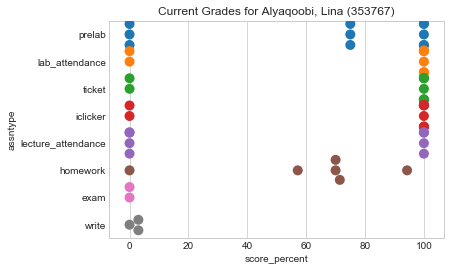

In [27]:
#Scatter of un-muted assignments by assignment grouping
sns.set_style("whitegrid")
sns.swarmplot(x="score_percent", y="assntype", size=10,data=grades2[(grades2['id']==stdid) & (grades2['muteflag']!=0) & (~grades2['assntype'].isin(['final','current','zzzz']))])
plt.axes().set_title('Current Grades for ' + stdname + ' (' + stdid + ')')

### 3.5) What grade is predicted for my students? <a class="anchor" id="thirdfifth"></a>

### Coming Soon...

* Calculated based on prelab, HW, exams, and attendance what the predicted grade for my student
* Try to figure out students that have a current grade higher/lower than the predicted grade
* Spot students trending up or down